In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import ast

In [7]:
K = 100

In [ ]:
df = pd.read_csv("omniart-paintings-filtered-clean.csv")

In [3]:
# Drop missing palette info
df = df.dropna(subset=['color_pallete', 'palette_count'])

# Parse strings as lists
df['color_pallete'] = df['color_pallete'].apply(ast.literal_eval)
df['palette_count'] = df['palette_count'].apply(ast.literal_eval)

In [4]:
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

In [5]:
# Build color-feature vectors We’ll use a flattened RGB vector, weighted by frequency.

def get_color_vector(colors, counts, top_n=10):
    total = sum(counts[:top_n])
    vec = []
    for color, count in zip(colors[:top_n], counts[:top_n]):
        weight = count / total  # normalized frequency
        rgb = hex_to_rgb(color)
        vec.extend([c * weight for c in rgb])  # weighted RGB
    # Pad with zeros if less than top_n
    while len(vec) < top_n * 3:
        vec.extend([0, 0, 0])
    return vec

In [8]:
df['color_vector'] = df.apply(lambda row: get_color_vector(row['color_pallete'], row['palette_count']), axis=1)
X = np.array(df['color_vector'].tolist())

In [9]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [10]:
# Clustering (KMeans)
kmeans = KMeans(n_clusters=K, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


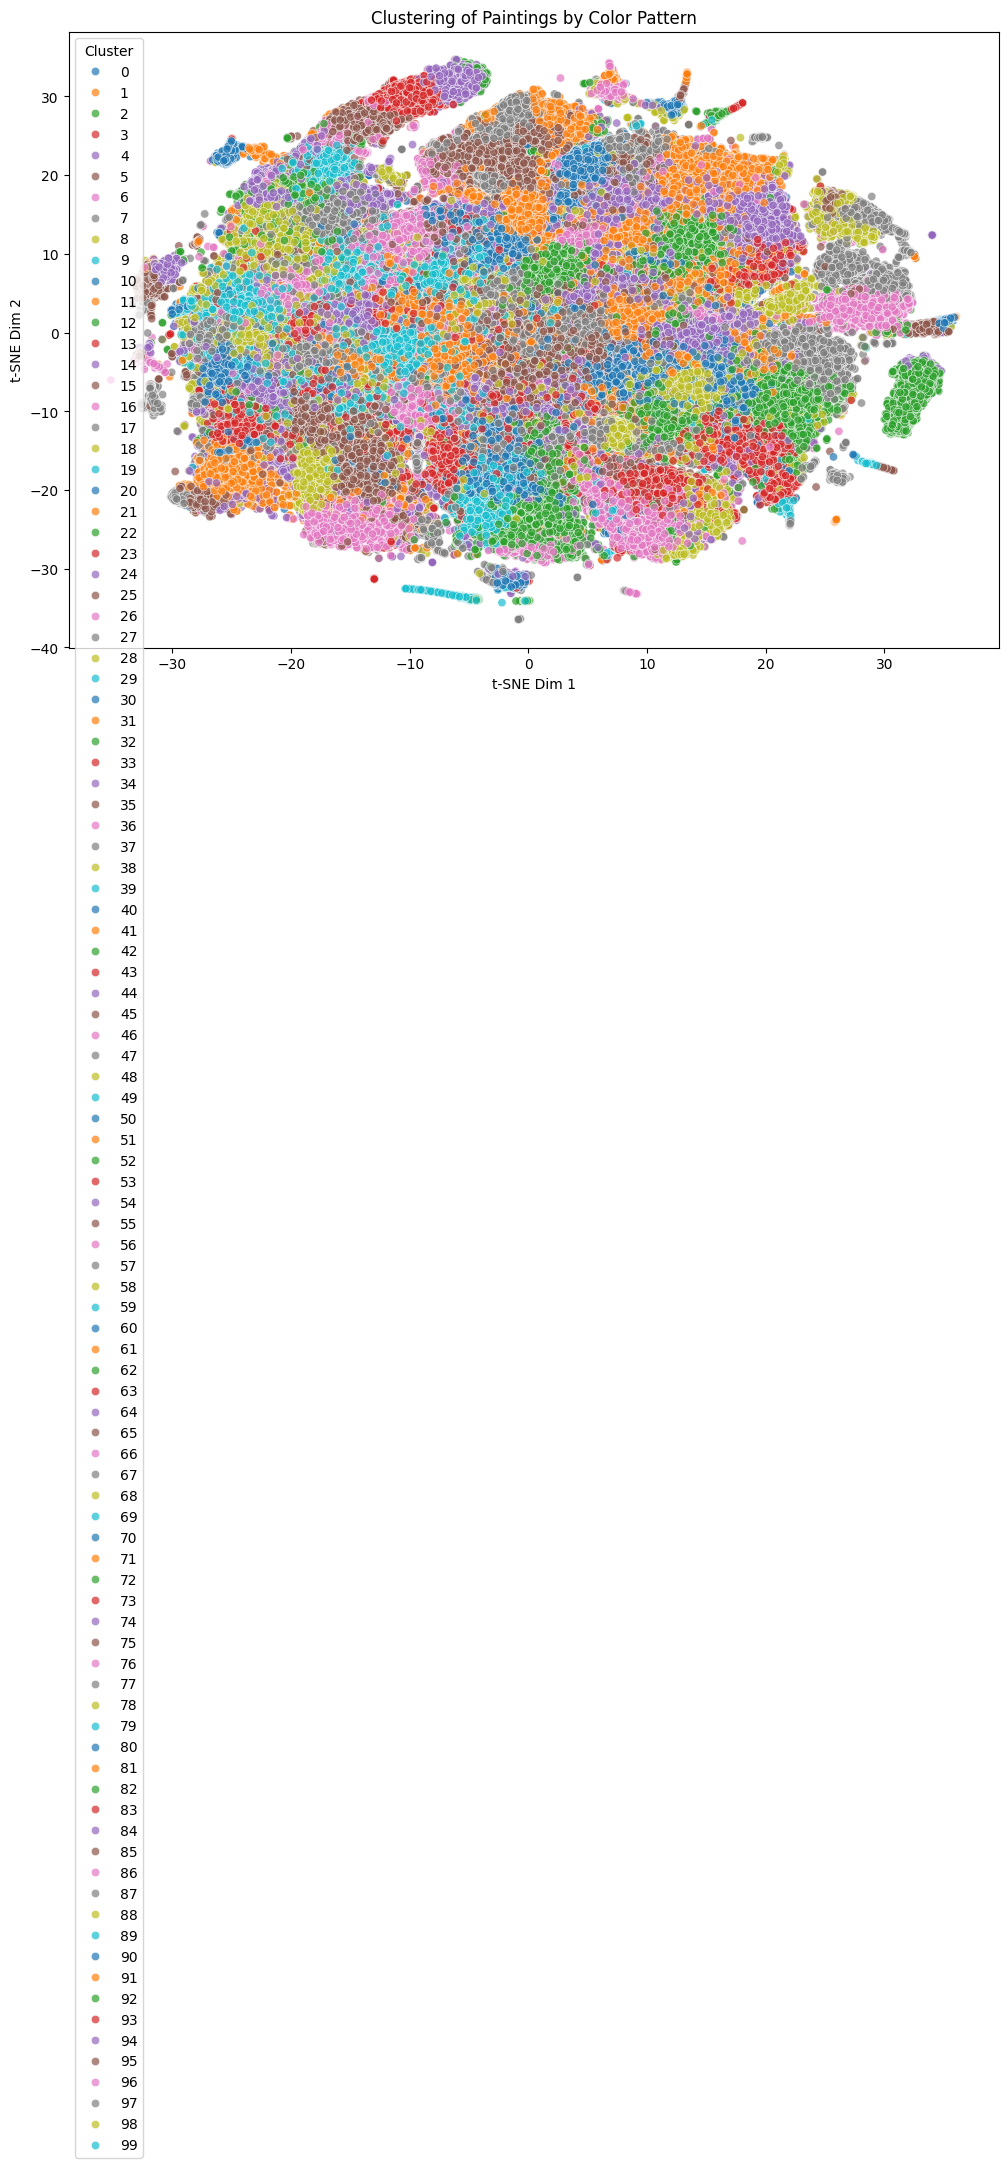

In [11]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=df['cluster'],
    palette='tab10',
    alpha=0.7
)
plt.title("Clustering of Paintings by Color Pattern")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster")
plt.show()